# Generating figures for the VI paper

In [1]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns
from numpy import genfromtxt
from autocorr_time import integrated_time
from matplotlib.patches import Patch

In [2]:
# Which data to load?
# E_min : [0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 2.609, 3.586, 4.332, 5.475]
# E_max : [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 2.624, 3.598, 4.342, 5.484]
E_min = 0.676 # MeV
E_max = 5.484 # MeV
which_data = 'som'

loader = DataLoader(E_min, E_max, which_data)

data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

plot_numbers = np.arange(0, 10)

## SONIK Data for 3He-4He elastic scattering

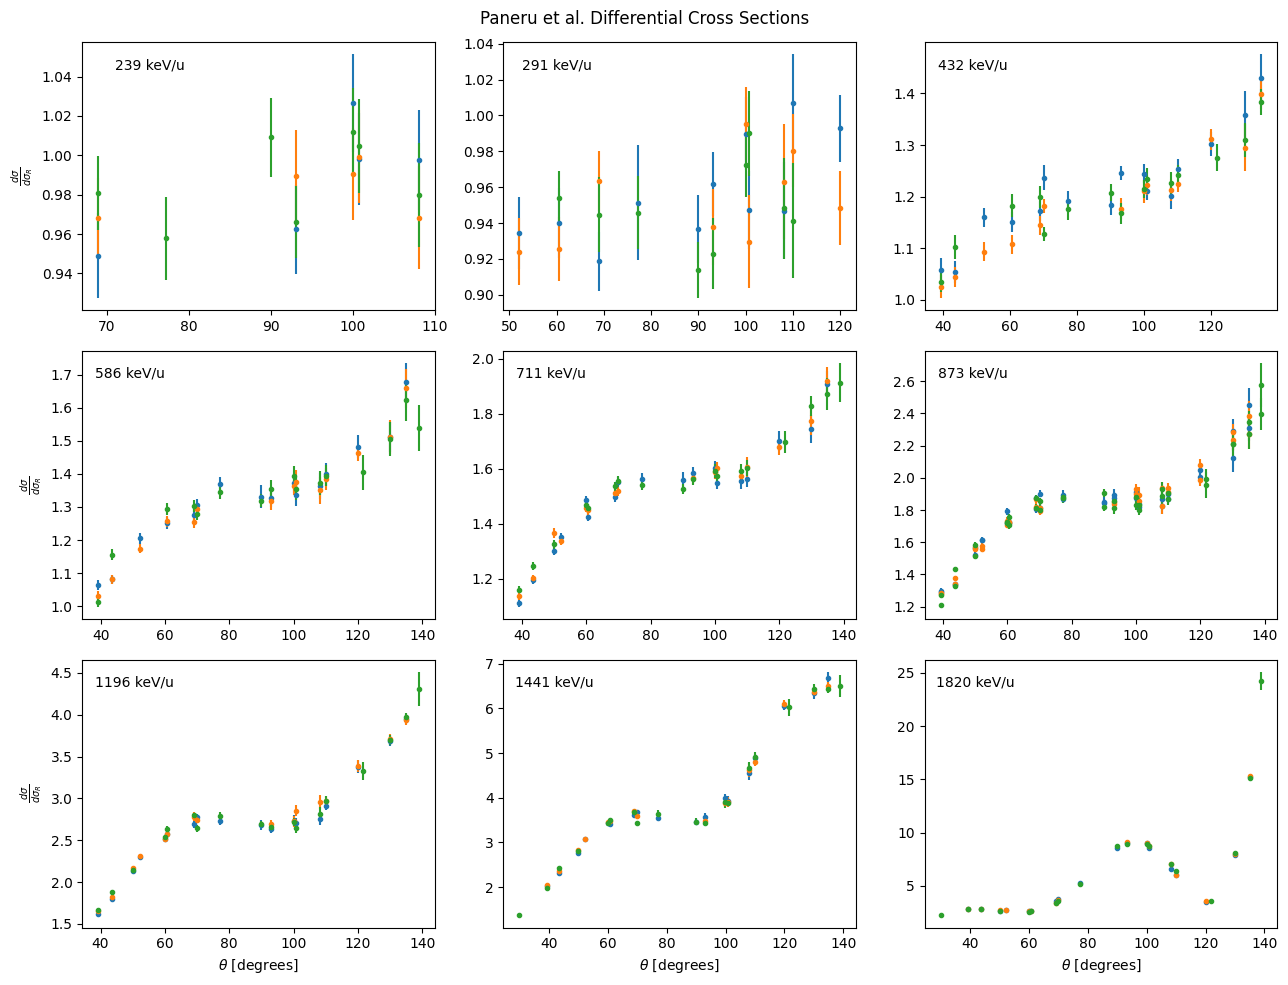

In [3]:
# Set up root path for the data
root_path = './'

# Set up the list of paths to the data
barnard_paths = [root_path + 'barnard_data/barnard5477.txt',
                root_path + 'barnard_data/barnard6345.txt',
                root_path + 'barnard_data/barnard7395.txt',
                root_path + 'barnard_data/barnard9003.txt',
                root_path + 'barnard_data/barnard10460.txt',
                root_path + 'barnard_data/barnard11660.txt',
                root_path + 'barnard_data/barnard12530.txt',
                root_path + 'barnard_data/barnard14080.txt']

som_paths = [root_path + 'SOM/som_cm_int1.npy',
            root_path + 'SOM/som_cm_int2.npy',
            root_path + 'SOM/som_cm_int3.npy']

# Load in the data, specific to the set and the E_max
data_E_max = E_max
data_which_data = which_data

# Handle Barnard set first
barnard_data_list = []
for path in barnard_paths:
    barnard_data_list.append(np.loadtxt(path))

# Handle Som set
som_data_list = []
l_som = [] # For Som normalization
l_som_energies = []
for path in som_paths:
    data_set = np.load(path, allow_pickle = True)
    som_data_list.append(data_set)
    l_som_energies.append([data_set[i][:, 0][0] for i in range(len(data_set))])
    l_som.append([len(data_set[j]) for j in range(len(data_set))])

# Concatenate the datasets into arrays
barnard_data = np.concatenate(barnard_data_list)
som_temp = np.concatenate(np.concatenate(som_data_list)) 
l_som_energies = np.array(l_som_energies)
# 2x concatenate because it is a list of lists

# For some reason, the Som data is formatted [E, theta, cs, err] so I swap the
# columns to match the Barnard set followint [theta, E, cs, err]
som_data = np.column_stack([som_temp[:, 1], som_temp[:, 0], som_temp[:, 2], som_temp[:, 3]])

# Cap the energy at E_max
# NOTE: The Barnard data has lowest E at 2.439 MeV and the Som data has
# lowest E at 0.676 MeV
if data_E_max != None:
    barnard_indices = np.where(barnard_data[:, 1] <= data_E_max)
    som_indices = np.where(som_data[:, 1] <= data_E_max)
    barnard_data = barnard_data[barnard_indices]
    som_data = som_data[som_indices]

# Now select which data to use
if data_which_data == 'both':
    data = np.concatenate([barnard_data, som_data])
elif data_which_data == 'som':
    data = som_data
elif data_which_data == 'barnard':
    data = barnard_data
else:
    sys.stderr.write('Choose a \'which_data\': both, som, barnard...')
    sys.exit(-1)

fig, ax = plt.subplots(3, 3, figsize = (13, 10))

coords = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [1, 2], [2, 0], [2, 1], [2, 2]])
descriptions = ['239 keV/u', '291 keV/u', '432 keV/u', '586 keV/u', '711 keV/u', '873 keV/u', '873 keV/u', '1196 keV/u', '1441 keV/u', '1820 keV/u']

# Plot the data
for j in plot_numbers:
    if j == 6:
        continue
    for energy in l_som_energies[:, j]:
        indices = np.where(data[:, 1] == energy)
        tmp = data[indices]
        ax[coords[j][0], coords[j][1]].errorbar(tmp[:, 0], tmp[:, 2], yerr = tmp[:, 3], fmt = '.')
    desc_y = ax[coords[j][0], coords[j][1]].get_ybound()[0] + (ax[coords[j][0], coords[j][1]].get_ybound()[1] - ax[coords[j][0], coords[j][1]].get_ybound()[0]) * 0.9
    desc_x = 4 + ax[coords[j][0], coords[j][1]].get_xbound()[0]
    ax[coords[j][0], coords[j][1]].text(desc_x, desc_y, descriptions[j])

ax[0, 0].set_ylabel('$\\frac{d \sigma}{d \sigma_{R}}$')
ax[1, 0].set_ylabel('$\\frac{d \sigma}{d \sigma_{R}}$')
ax[2, 0].set_ylabel('$\\frac{d \sigma}{d \sigma_{R}}$')

ax[2, 0].set_xlabel('$\\theta$ [degrees]')
ax[2, 1].set_xlabel('$\\theta$ [degrees]')
ax[2, 2].set_xlabel('$\\theta$ [degrees]')

plt.suptitle('Paneru et al. Differential Cross Sections')
plt.tight_layout()
plt.show()

---------------
---------------
## VI / MC comparison
Define the plotting functions to overlay the corner plots and to label the quantiles

In [4]:
# Set up the labels
labels = ['$A_{0}$', '$r_{0}$', '$(C_{1}^{+})^{2}$', '$P_{1}^{+}$', '$(C_{1}^{-})^{2}$', '$P_{1}^{-}$']

# Set the colors
color1 = np.array([64, 111, 215]) / 255 # Dodgerblue
color2 = np.array([123, 218, 51]) / 255 # Lime

def overlay_corner(data1, data2, labels, fig_title, label1 = None, label2 = None):
    # Generate a figure and plot the first set
    fig = corner.corner(data1, labels = labels, quantiles = [0.16, 0.5, 0.84], color = color1)
    # Plot the second set on the figure in a different color
    corner.corner(data2, labels = labels, quantiles = [0.16, 0.5, 0.84], color = color2, fig = fig)

    add_quantiles_and_titles(fig, data1, data2, labels)
    plt.suptitle(fig_title)

    legend_elements = [Patch(facecolor = color1, label = label1), Patch(facecolor = color2, label = label2)]
    fig.legend(handles = legend_elements, loc = 'upper right', bbox_to_anchor=(0.95, 0.95))

    plt.show()


def add_quantiles_and_titles(fig, data1, data2, labels):
    # Compute the quantiles for each set
    quantiles1 = np.percentile(data1, [16, 50, 84], axis = 0)
    quantiles2 = np.percentile(data2, [16, 50, 84], axis = 0)

    # Define a multiplicative vertical shift for text
    shift = 0.05

    # Define a vertical shift for the smaller quantiles
    quant_shift = 0.01

    # Define the font sizes
    size1 = 14
    size2 = 9

    # Get an array of the axes
    axes = np.array(fig.axes).reshape((data1.shape[1], data1.shape[1]))

    # For each parameter
    for i in range(0, data1.shape[1]):
        ax = axes[i, i]
        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        y_text = ylim[1] + shift * (ylim[1] - ylim[0])

        # Add the vertical lines for the quantiles
        ax.axvline(quantiles1[0, i], color = color1, linestyle = 'dashed', alpha = 0.75)
        ax.axvline(quantiles1[1, i], color = color1, linestyle = 'dashed', alpha = 0.75)
        ax.axvline(quantiles1[2, i], color = color1, linestyle = 'dashed', alpha = 0.75)
        ax.axvline(quantiles2[0, i], color = color2, linestyle = 'dashed', alpha = 0.75)
        ax.axvline(quantiles2[1, i], color = color2, linestyle = 'dashed', alpha = 0.75)
        ax.axvline(quantiles2[2, i], color = color2, linestyle = 'dashed', alpha = 0.75)

        # Add the title
        t1 = ax.text(xlim[0], y_text, '{}='.format(labels[i]), color = 'black', fontsize = size1)

        # Get the end of the title
        renderer = fig.canvas.get_renderer()
        bbox = t1.get_window_extent(renderer = renderer)
        bbox_data = bbox.transformed(ax.transAxes.inverted())
        x_shift1 = ((bbox_data.x1 - bbox_data.x0) * (xlim[1] - xlim[0]) * 1.1)

        # Add the 0.5 quantile labels
        t2 = ax.text(xlim[0] + x_shift1, y_text + (0.125 * y_text), '{:.4f}'.format(quantiles1[1, i]), color = color1, fontsize = size1)
        t3 = ax.text(xlim[0] + x_shift1, y_text, '{:.4f}'.format(quantiles2[1, i]), color = color2, fontsize = size1)

        # Get the end of the 0.5 quantile label
        bbox = t2.get_window_extent(renderer = renderer)
        bbox_data = bbox.transformed(ax.transAxes.inverted())
        x_shift2 = ((bbox_data.x1 - bbox_data.x0) * (xlim[1] - xlim[0]) * 1.05)

        # Add the 0.16 quantile labels
        ax.text(xlim[0] + x_shift1 + x_shift2, (y_text + (0.125 * y_text)) - (y_text * quant_shift), '- {:.4f}'.format(quantiles1[1, i] - quantiles1[0, i]), color = color1, fontsize = size2)
        ax.text(xlim[0] + x_shift1 + x_shift2, (y_text) - (y_text * quant_shift), '- {:.4f}'.format(quantiles2[1, i] - quantiles2[0, i]), color = color2, fontsize = size2)

        # Add the 0.84 quantile labels
        ax.text(xlim[0] + x_shift1 + x_shift2, y_text + (0.1875 * y_text) - (y_text * quant_shift), '+{:.4f}'.format(quantiles1[2, i] - quantiles1[1, i]), color = color1, fontsize = size2)
        ax.text(xlim[0] + x_shift1 + x_shift2, y_text + (0.0625 * y_text) - (y_text * quant_shift), '+{:.4f}'.format(quantiles2[2, i] - quantiles2[1, i]), color = color2, fontsize = size2)

----------

### 2.6 no theory cov

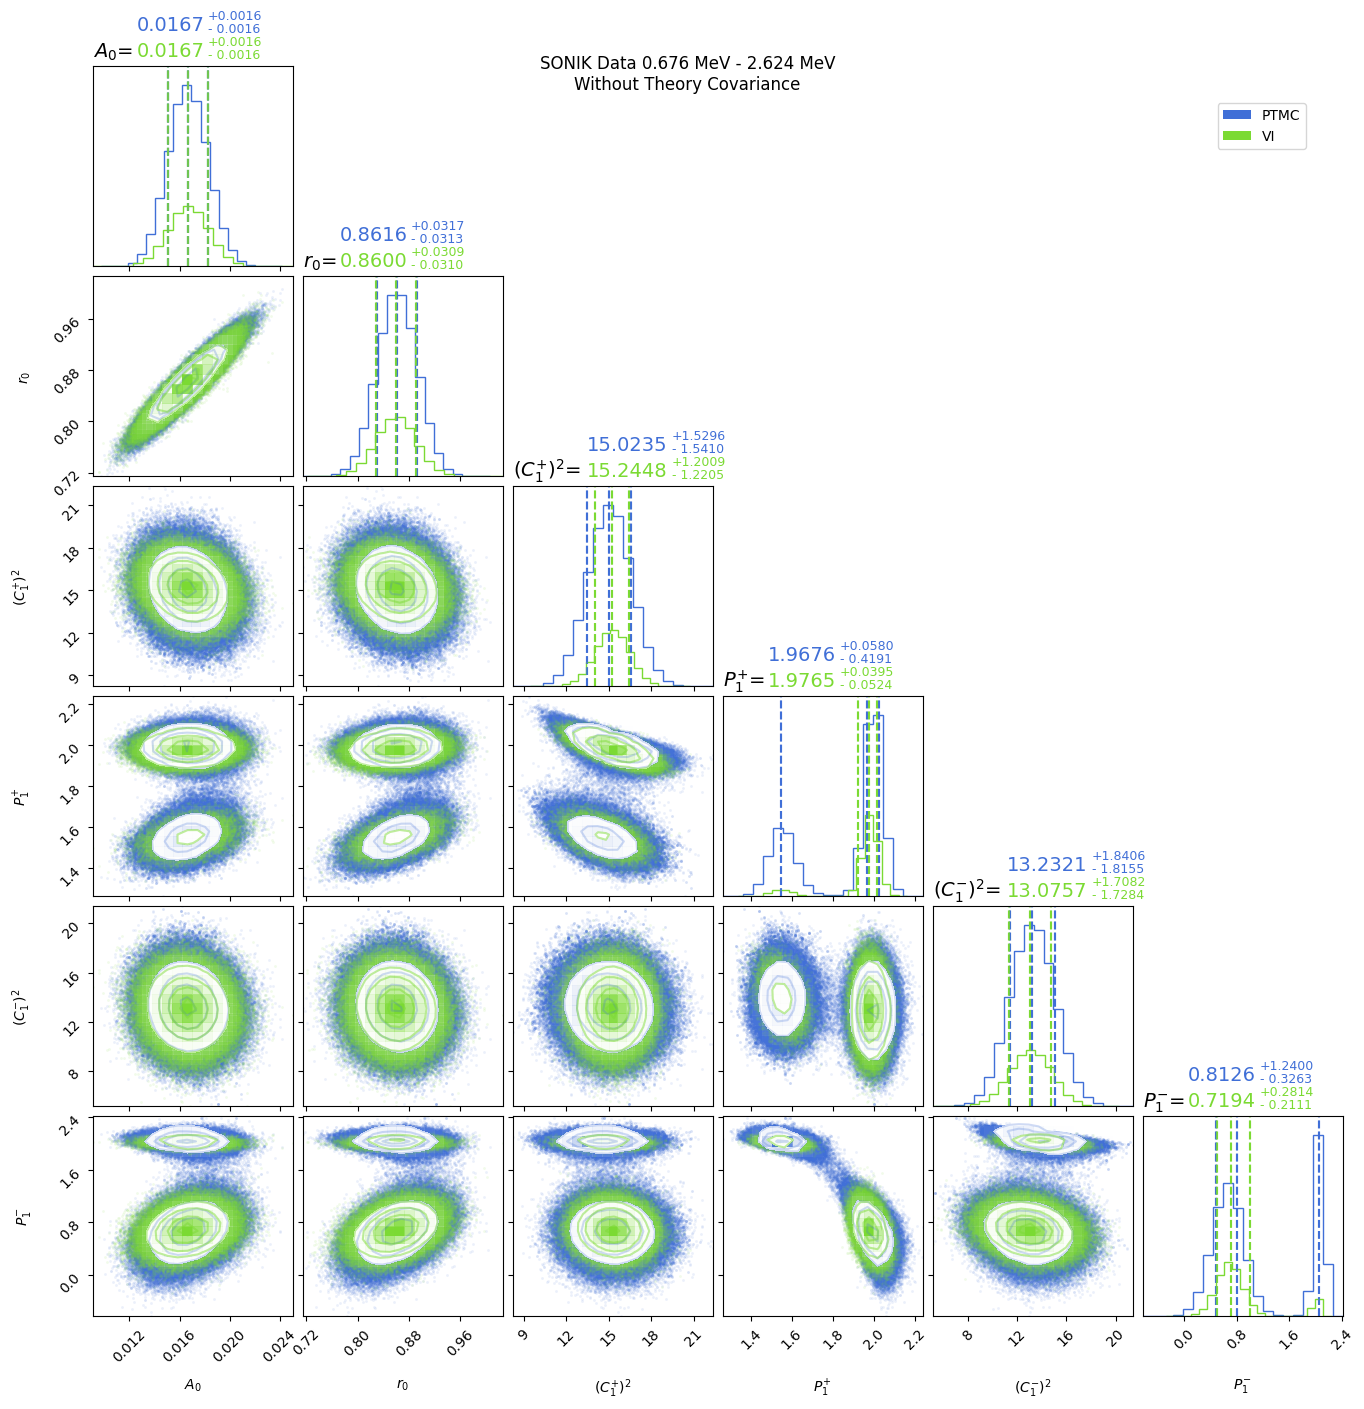

In [5]:
vi_26_n = genfromtxt('./production_samples/VI_samples/2_6_no_cov.csv', delimiter = ',')
mc_26_n_not_flat = np.load('./production_samples/samples/2_6_no_cov.npz')['arr_0']
mc_26_n_not_flat = mc_26_n_not_flat[0]
mc_26_n_not_flat = np.swapaxes(mc_26_n_not_flat, 0, 1)

# Compute the autocorrelation times and thin
ac_s = integrated_time(mc_26_n_not_flat)
ac = int(np.ceil(np.max(ac_s)))
mc_26_n_not_flat = mc_26_n_not_flat[::ac, :, :]

# Flatten the samples
len0, len1, len2 = mc_26_n_not_flat.shape
mc_26_n = np.reshape(mc_26_n_not_flat, (len0 * len1, len2))

overlay_corner(mc_26_n[:, :6], vi_26_n[1:, 1:], labels, 'SONIK Data 0.676 MeV - 2.624 MeV\nWithout Theory Covariance', label1 = 'PTMC', label2 = 'VI')

--------
### 2.6 yes theory cov

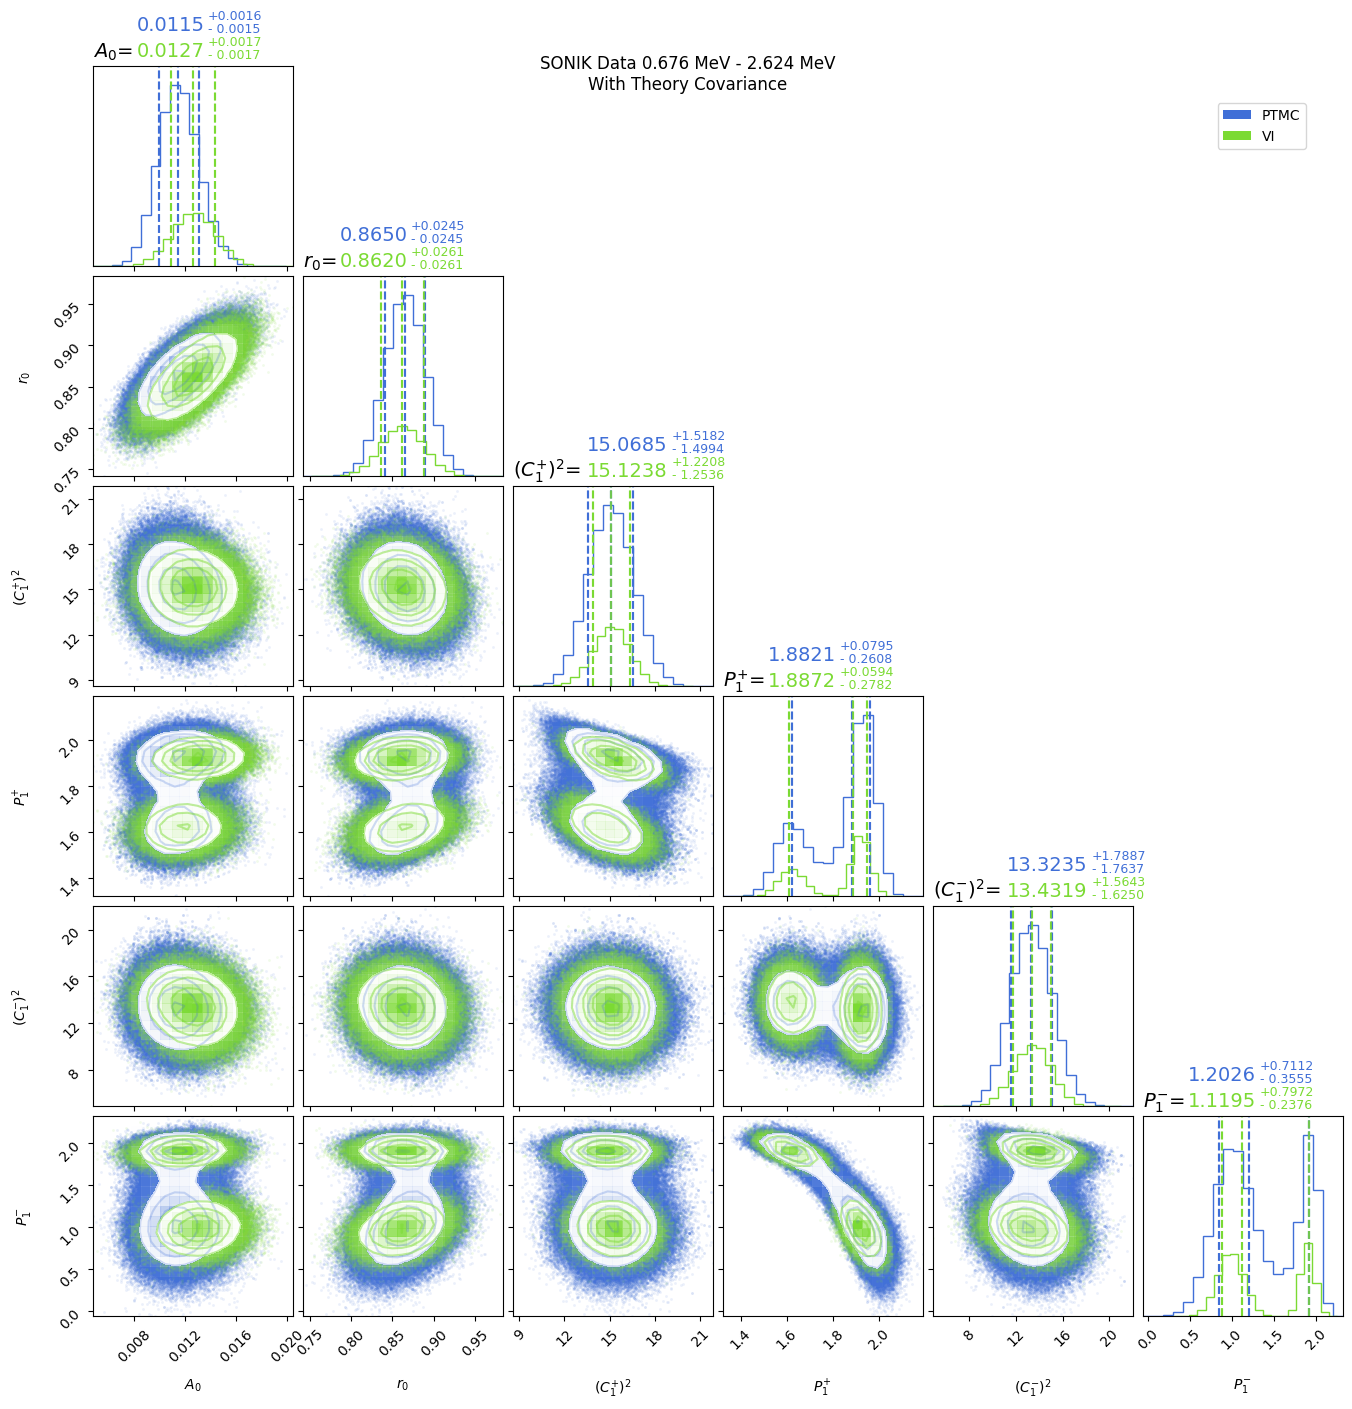

In [6]:
vi_26_y = genfromtxt('./production_samples/VI_samples/2_6_yes_cov.csv', delimiter = ',')
mc_26_y_not_flat = np.load('./production_samples/samples/2_6_yes_cov.npz')['arr_0']
mc_26_y_not_flat = mc_26_y_not_flat[0]
mc_26_y_not_flat = np.swapaxes(mc_26_y_not_flat, 0, 1)

# Compute the autocorrelation times and thin
ac_s = integrated_time(mc_26_y_not_flat)
ac = int(np.ceil(np.max(ac_s)))
mc_26_y_not_flat = mc_26_y_not_flat[::ac, :, :]

# Flatten the samples
len0, len1, len2 = mc_26_y_not_flat.shape
mc_26_y = np.reshape(mc_26_y_not_flat, (len0 * len1, len2))

overlay_corner(mc_26_y[:, :6], vi_26_y[1:, 1:], labels, 'SONIK Data 0.676 MeV - 2.624 MeV\nWith Theory Covariance', label1 = 'PTMC', label2 = 'VI')

----------------
### 4.3 no theory cov

In [7]:
# Load in the samples
reader = emcee.backends.HDFBackend('./production_samples/samples/4_3_no_cov.h5')
samples_not_flat = reader.get_chain()
samples_flat = reader.get_chain(flat = True)

n_burn = 50000

# Look at the variances within each chain to determine if the walker is moving enough or if it is stuck.
within_chain_means = np.mean(samples_not_flat[n_burn:, :, :], axis = 0)

# Create an empty array of the within chain variances
within_chain_var = np.empty(within_chain_means.shape)

# Run a for loop across all walkers to compute the within chain variance
for i in range(0, within_chain_means.shape[0]):
    within_chain_var[i, :] = np.sum(np.square(within_chain_means[i, :] - samples_not_flat[n_burn:, i, :]), axis = 0) / (samples_not_flat.shape[0] // 2)

# Get the typical within chain variance W for each parameter
W = np.median(within_chain_var, axis = 0)


# Now we need to loop over each chain for each parameter to see how it compares to the typical variance
bad_indices = []
ratios = np.empty(within_chain_means.shape)
# Loop over each parameter
for i in range(0, within_chain_means.shape[1]):
    # Loop over the walkers
    for j in range(0, within_chain_means.shape[0]):
        ratio = np.sum(within_chain_var[j, i] / W[i]) / within_chain_means.shape[1]
        ratios[j, i] = ratio

# Sum along each parameter, this value should be very close to 1.0. Select out the bad indices
total_normalized_ratios = np.sum(ratios, axis = 1)
bad_indices = np.where(total_normalized_ratios <= 0.9)[0]
print('Found {} bad walkers at indices:'.format(bad_indices.shape[0]))
print(bad_indices)

if bad_indices.shape[0] != 0:
    # Remove the bad walkers
    samples_not_flat = np.delete(samples_not_flat, bad_indices, axis = 1)

# Thin according to the burn-in time
thinned_samples_not_flat = samples_not_flat[n_burn:, :, :]

# Compute the autocorrelation times for each parameter
ac_s = reader.get_autocorr_time(discard = n_burn, tol = 0)
ac = int(np.max(ac_s))

# Thin according to the autocorrelation time
thinned_samples_not_flat = thinned_samples_not_flat[::ac, :, :]

# Flatten the samples and log-prob
len0, len1, len2 = thinned_samples_not_flat.shape
mc_43_n = np.reshape(thinned_samples_not_flat, (len0 * len1, len2))

print('AC: {}'.format(ac))

vi_43_n = genfromtxt('./production_samples/VI_samples/4_3_no_cov.csv', delimiter = ',')

Found 0 bad walkers at indices:
[]
AC: 287


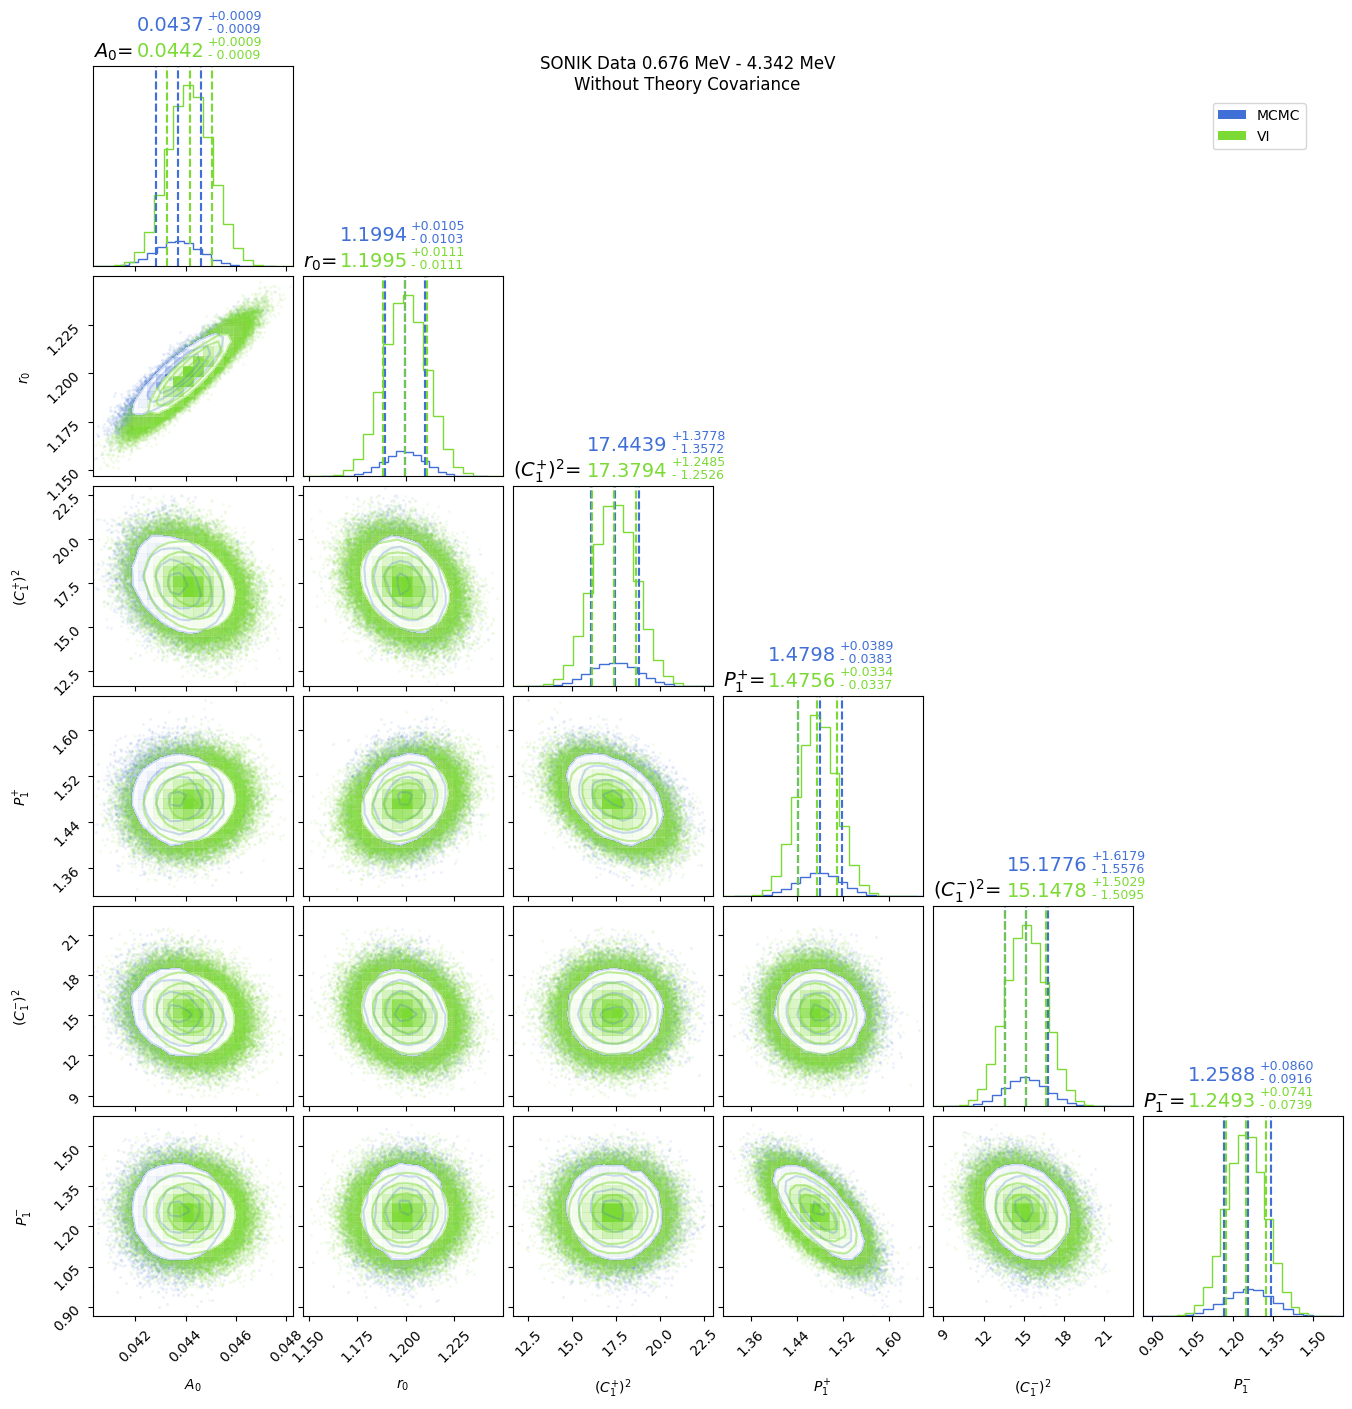

In [8]:
overlay_corner(mc_43_n[:, :6], vi_43_n[1:, 1:], labels, 'SONIK Data 0.676 MeV - 4.342 MeV\nWithout Theory Covariance', label1 = 'MCMC', label2 = 'VI')

---------------
### 4.3 yes theory cov

In [10]:
# Load in the samples
reader = emcee.backends.HDFBackend('./production_samples/samples/4_3_yes_cov.h5')
samples_not_flat = reader.get_chain()
samples_flat = reader.get_chain(flat = True)

n_burn = 50000

# Look at the variances within each chain to determine if the walker is moving enough or if it is stuck.
within_chain_means = np.mean(samples_not_flat[n_burn:, :, :], axis = 0)

# Create an empty array of the within chain variances
within_chain_var = np.empty(within_chain_means.shape)

# Run a for loop across all walkers to compute the within chain variance
for i in range(0, within_chain_means.shape[0]):
    within_chain_var[i, :] = np.sum(np.square(within_chain_means[i, :] - samples_not_flat[n_burn:, i, :]), axis = 0) / (samples_not_flat.shape[0] // 2)

# Get the typical within chain variance W for each parameter
W = np.median(within_chain_var, axis = 0)


# Now we need to loop over each chain for each parameter to see how it compares to the typical variance
bad_indices = []
ratios = np.empty(within_chain_means.shape)
# Loop over each parameter
for i in range(0, within_chain_means.shape[1]):
    # Loop over the walkers
    for j in range(0, within_chain_means.shape[0]):
        ratio = np.sum(within_chain_var[j, i] / W[i]) / within_chain_means.shape[1]
        ratios[j, i] = ratio

# Sum along each parameter, this value should be very close to 1.0. Select out the bad indices
total_normalized_ratios = np.sum(ratios, axis = 1)
bad_indices = np.where(total_normalized_ratios <= 0.9)[0]
print('Found {} bad walkers at indices:'.format(bad_indices.shape[0]))
print(bad_indices)

if bad_indices.shape[0] != 0:
    # Remove the bad walkers
    samples_not_flat = np.delete(samples_not_flat, bad_indices, axis = 1)

# Thin according to the burn-in time
thinned_samples_not_flat = samples_not_flat[n_burn:, :, :]

# Compute the autocorrelation times for each parameter
ac_s = reader.get_autocorr_time(discard = n_burn, tol = 0)
ac = int(np.max(ac_s))

# Thin according to the autocorrelation time
thinned_samples_not_flat = thinned_samples_not_flat[::ac, :, :]

# Flatten the samples and log-prob
len0, len1, len2 = thinned_samples_not_flat.shape
mc_43_y = np.reshape(thinned_samples_not_flat, (len0 * len1, len2))

print('AC: {}'.format(ac))

vi_43_y = genfromtxt('./production_samples/VI_samples/4_3_yes_cov.csv', delimiter = ',')

Found 1 bad walkers at indices:
[27]
AC: 383


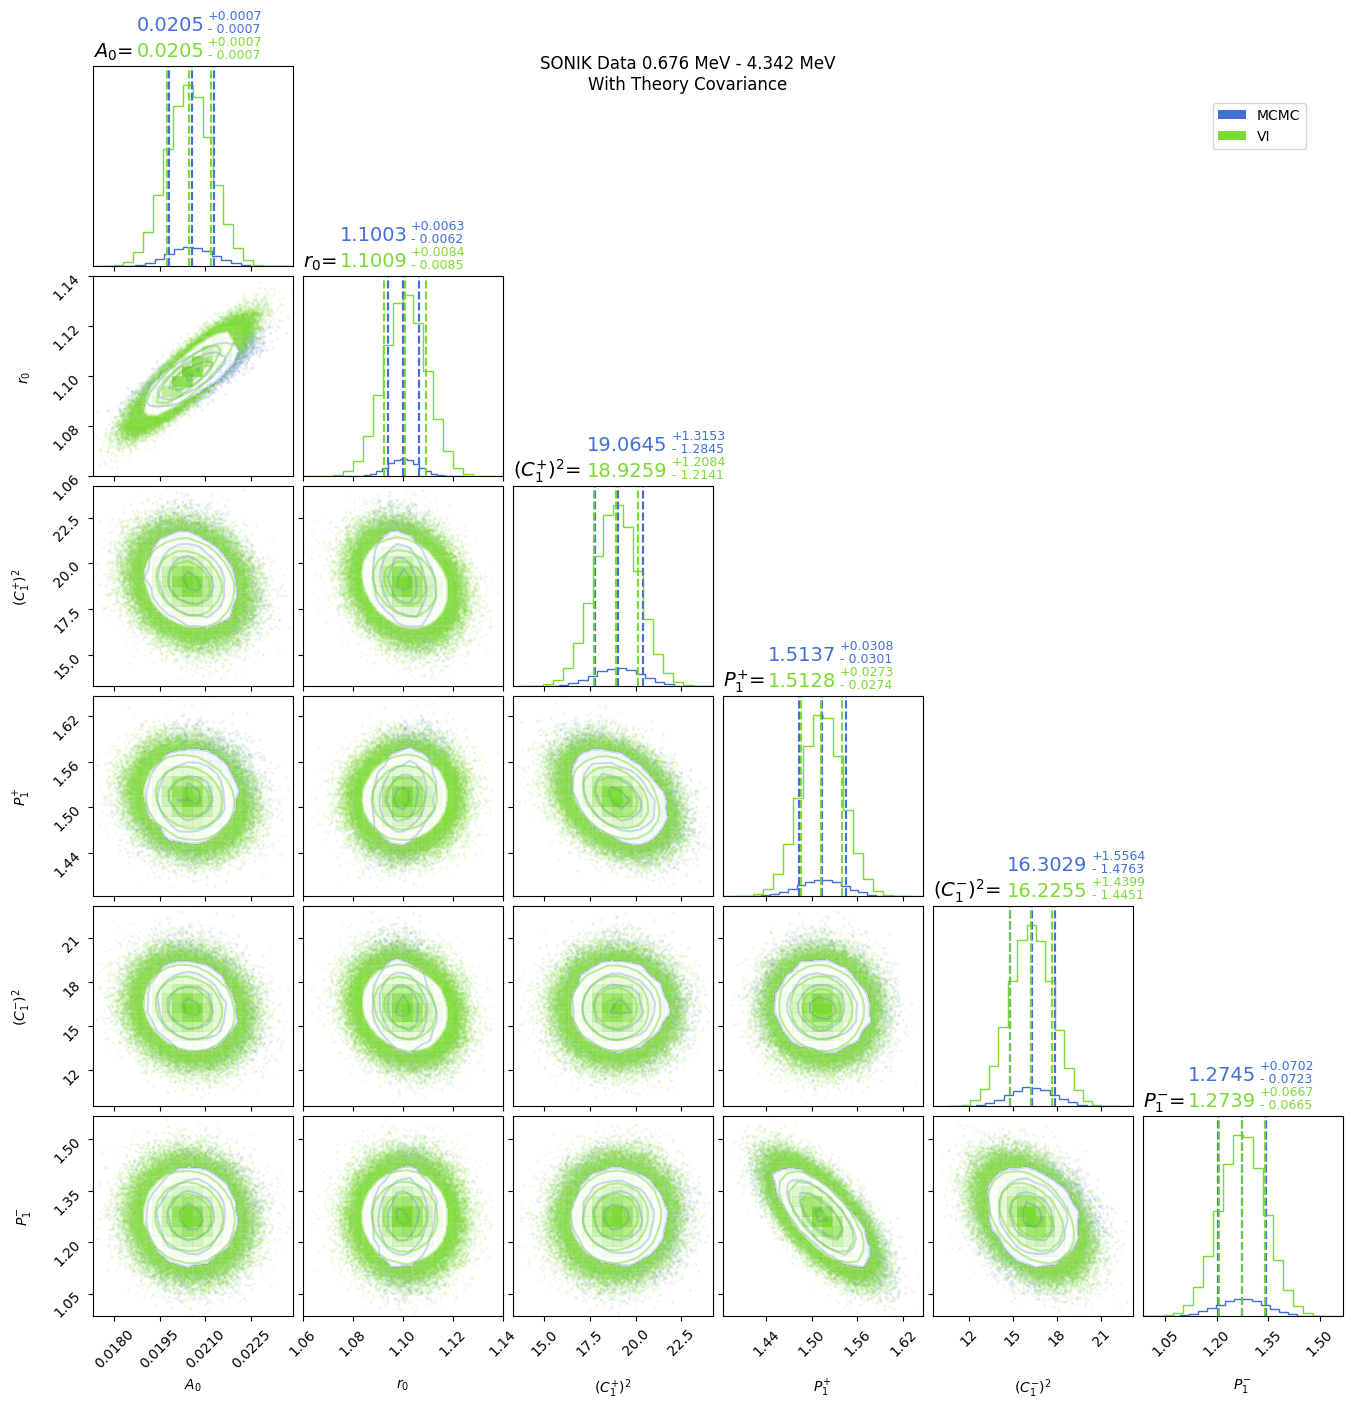

In [11]:
overlay_corner(mc_43_y[:, :6], vi_43_y[1:, 1:], labels, 'SONIK Data 0.676 MeV - 4.342 MeV\nWith Theory Covariance', label1 = 'MCMC', label2 = 'VI')

------------
------------